In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/root/data/imagenette_wb/train/',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
    )

number_of_classes = 10

Found 10475 images belonging to 10 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    '/root/data/imagenette_wb/val',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False
    )

Found 3925 images belonging to 10 classes.


In [ ]:
data = []
labels = []

for _ in range(len(train_generator)):
    X_batch, y_batch = next(train_generator)
    data.extend(X_batch)
    labels.extend(y_batch)
    
labels_scalar = [np.argmax(label) for label in labels]

In [4]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2)
data_np = np.array(data)
data_flat = data_np.reshape(len(data_np), -1)
data_2d = tsne.fit_transform(data_flat)

# Train from scratch

In [4]:
from keras.applications import ResNet101

model = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-08 11:12:12.340012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30727 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:02.0, compute capability: 7.0


# Using pretrained model

In [5]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('./model/resnet101.h5')

In [4]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=105,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50


In [38]:
model.save('./model/resnet101.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
model.layers[-2]

In [7]:
from keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(train_generator)

2023-11-08 11:13:33.705991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


105/105 [==============================] - 65s 580ms/step


In [ ]:
validation_features = feature_extractor.predict(validation_generator)

In [11]:
dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator = dis_datagen.flow_from_directory(
    '/root/data/syn_data/imagenette/23/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False)

distilled_features = feature_extractor.predict(distilled_generator)

Found 1000 images belonging to 10 classes.
20/20 [==============================] - 3s 93ms/step


# Visualization

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
                                     
tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=40)
train_features_2d = tsne.fit_transform(train_features)

In [30]:
predictions = model.predict(train_generator)

105/105 [==============================] - 56s 512ms/step


In [43]:
labels = np.argmax(predictions, axis=-1)
labels

array([1, 6, 8, ..., 5, 1, 0])

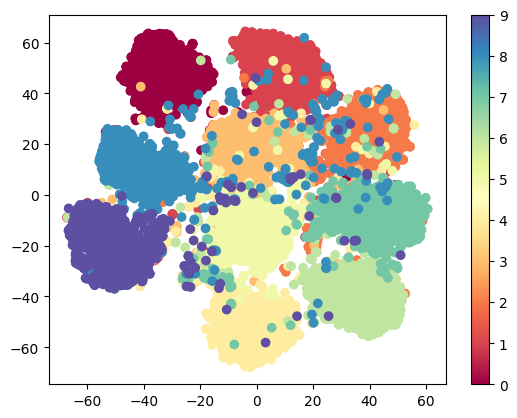

In [10]:
import numpy as np

labels = train_generator.classes

plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=labels, cmap='Spectral')
plt.colorbar()
plt.show()

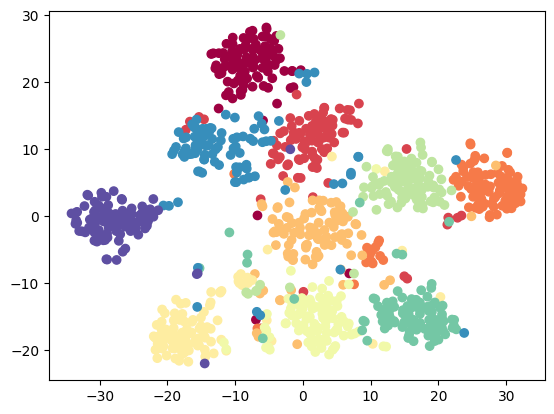

In [12]:
distilled_features_2d = tsne.fit_transform(distilled_features)
labels = distilled_generator.classes
plt.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], c=labels, cmap='Spectral')
plt.show()

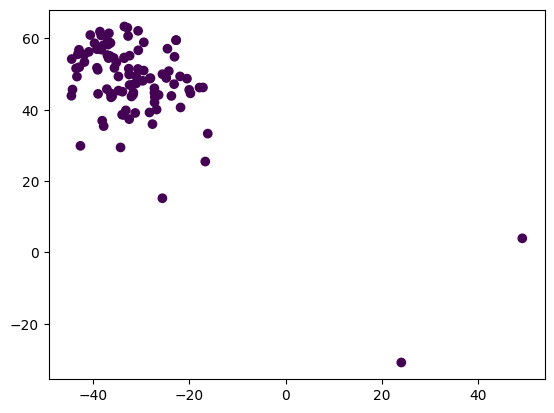

In [13]:
interested_classes = [9]
indices = [i for i, label in enumerate(labels) if label in interested_classes]

selected_features = train_features_2d[indices]
selected_labels = np.array([labels[i] for i in indices])

plt.scatter(selected_features[:, 0], selected_features[:, 1], c=selected_labels)
plt.show()

## Umap

ValueError: 'c' argument has 104750 elements, which is inconsistent with 'x' and 'y' with size 10475.

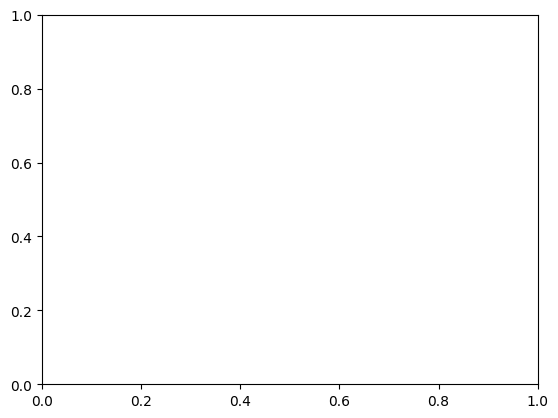

In [ ]:
import umap

#Apply UMAP
reducer = umap.UMAP()
umap_results = reducer.fit_transform(train_features)

# Visualize the results
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_scalar, cmap='Spectral')
plt.show()